# Task 1 - Sentiment Model

## Data Extraction - code from data_loader_demo.ipynb

In [80]:
%load_ext autoreload
%autoreload 2

import warnings

# Use HuggingFace's datasets library to access the financial_phrasebank dataset
from datasets import load_dataset
from sklearn.model_selection import train_test_split

# Exploration
import matplotlib.pyplot as plt
import seaborn as sns

# Feature Engineering
import numpy as np
import pandas as pd

import nltk
import re
from sklearn.feature_extraction.text import TfidfVectorizer

# Modelling
import params as p

from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score, plot_confusion_matrix

from sklearn.ensemble import RandomForestClassifier

import optuna

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [81]:
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/jamesstephenson/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

### Settings

In [82]:
warnings.simplefilter(action='ignore', category=FutureWarning)

### Import Data

In [83]:
# The financial_phrasebank dataset is available in four variations. It has no predefined train/validation/test splits.
# Each data point was annotated by 5-8 people, then their annotations were combined. 
# Each variation of the dataset contains examples with different levels of agreement. 
# Let's use the one containing all data points where at least 50% of the annotators agreed on the label.
dataset = load_dataset(
    "financial_phrasebank", 
    'sentences_50agree' # Select variation of the dataset
)

print(f'The dataset is a dictionary with two splits: \n\n{dataset}')

Reusing dataset financial_phrasebank (/Users/jamesstephenson/.cache/huggingface/datasets/financial_phrasebank/sentences_50agree/1.0.0/a6d468761d4e0c8ae215c77367e1092bead39deb08fbf4bffd7c0a6991febbf0)
100%|██████████| 1/1 [00:00<00:00, 42.85it/s]

The dataset is a dictionary with two splits: 

DatasetDict({
    train: Dataset({
        features: ['sentence', 'label'],
        num_rows: 4846
    })
})


In [84]:
# Split test data from training data
train_sentences, test_sentences, train_labels, test_labels = train_test_split(
    dataset["train"]['sentence'], 
    dataset["train"]['label'], 
    test_size=0.2, 
    stratify=dataset["train"]['label']  # make sure the same proportion of labels is in the test set and training set
)

In [85]:
# label 0 = negative, 1 = neutral, 2 = positive
print(f'How many instances in the train dataset? \n\n{len(train_sentences)}')
print('')
print(f'What does one instance look like? \n\n{train_sentences[234]}')

How many instances in the train dataset? 

3876

What does one instance look like? 

Under the agreement Ponsse will provide forest machine maintenance services to Stora Enso 's Russian wood procurement operations .


It may also be necessary to create a _validation_ set (also called 'development' set or 'devset'). The validation set can be used to compute performance of your model when tuning hyperparameters,  optimising combinations of features, or looking at the errors your model makes before improving it. This allows you to hold out the test set to give a fair evaluation of the model and how well it generalises to new examples. This avoids tuning the model to specifso it gets good performance on the test set examples. 

In [86]:
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_sentences, train_labels, test_size=0.25, stratify=train_labels)


In [87]:
print(f'How many instances in the validation dataset? \n\n{len(val_sentences)}\n')
print(f'How many instances in the test dataset? \n\n{len(test_sentences)}')

How many instances in the validation dataset? 

969

How many instances in the test dataset? 

970


## Data Exploration

In [88]:
train = pd.DataFrame({'sentences' : train_sentences, 'labels' : train_labels})

### Very Brief Response Analysis

Should only need to do this for train due to random split. So would expect to see the same structure for test and val

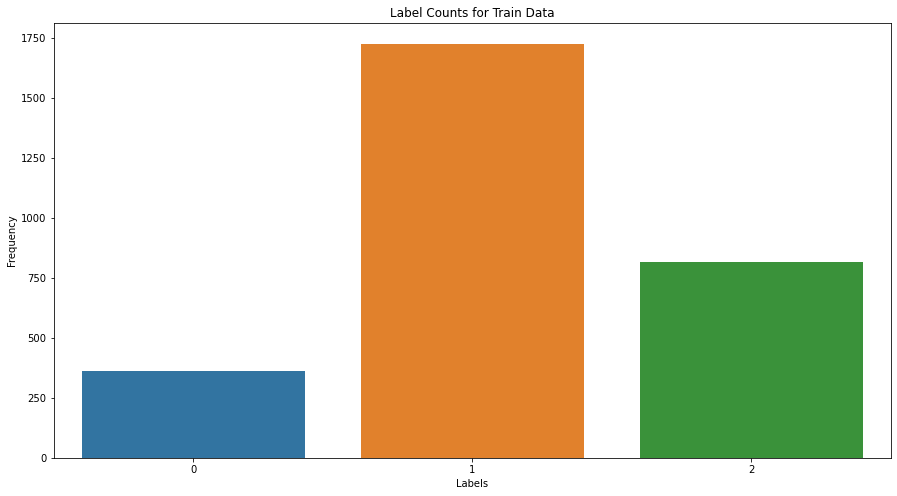

In [89]:
fig, ax = plt.subplots(nrows = 1, ncols = 1, figsize = (15, 8))

ax = sns.countplot(data = train, x = 'labels').set(title = 'Label Counts for Train Data')

plt.xlabel("Labels")
plt.ylabel("Frequency")
plt.xticks(rotation = 0)

plt.show()

There is a slight imbalance in labels, but nothing that should be an issue. If we find this is an issue later on, we can perform some over or under sampling.

# Featuring Engineering

### Sentence Processing

In [90]:
# Remove some stopwords to capture negation in n-grams if possible
stop_words = nltk.corpus.stopwords.words('english')
stop_words.remove('no')
stop_words.remove('not')
stop_words.remove('but')

# Load up a WordNet Lemmatizer
wnl = nltk.stem.WordNetLemmatizer()

# Define a function to get the position tag for each word - this helps to lemmatize words correctly with context
def get_wordnet_pos(word: str):
        '''Map POS tag to first character lemmatize() accepts
        
        Arguments:
            word (str): word to find wordnet position tag for'''
        
        tag = nltk.pos_tag([word])[0][1][0].upper()

        tag_dict = {
            'J': nltk.corpus.wordnet.ADJ,
            'N': nltk.corpus.wordnet.NOUN,
            'V': nltk.corpus.wordnet.VERB,
            'R': nltk.corpus.wordnet.ADV
            }

        return tag_dict.get(tag, nltk.corpus.wordnet.NOUN)

def text_preprocess(sentence: str):
    '''Preprocesses the inputted sentence and does the following: sets to lowercase,
    removes unwanted characters, lemmatizes and removes stopwords
    
    Arguments:
        sentence (str): sentence to be processed

    Returns:
        sentence (str): processed sentence'''

    # Set to lower case
    sentence = str(sentence).lower()
    
    # Remove non-letter characters and replace the abbreviation 'mn' for million
    sentence = re.sub(r'[^a-zA-Z]',r' ', sentence)
    sentence = re.sub('mn', 'million', sentence)

    sentence_tokenize = nltk.word_tokenize(sentence)

    # Wordnet lemmatizer with position tagging to give context
    sentence = ' '.join([wnl.lemmatize(word, get_wordnet_pos(word)) for word in sentence_tokenize])
    
    # Removal of Stopwords
    sentence = ' '.join([word for word in sentence_tokenize if word not in stop_words])
    
    return sentence

# Turn the above function into a vectorized function to work on columns for sentences
vect_text_preprocess = np.vectorize(text_preprocess)

In [91]:
clean_train_sentences = vect_text_preprocess(train_sentences)
clean_test_sentences = vect_text_preprocess(test_sentences)
clean_val_sentences = vect_text_preprocess(val_sentences)

#### TF-IDF Vectorizer

We will be using a TF-IDF Vectorizer to vectorize our sentences before modelling. We will be setting the `ngram_range = (1, 2)` so we can also build columns for bi-grams.

In [92]:
tfidf = TfidfVectorizer(min_df = 0.0, max_df = 1.0, ngram_range = (1, 2))

In [93]:
X_train = tfidf.fit_transform(clean_train_sentences).toarray()
X_train = pd.DataFrame(X_train, columns = tfidf.get_feature_names_out())

X_test = tfidf.transform(clean_test_sentences).toarray()
X_test = pd.DataFrame(X_test, columns = tfidf.get_feature_names_out())

X_val = tfidf.transform(clean_val_sentences).toarray()
X_val = pd.DataFrame(X_val, columns = tfidf.get_feature_names_out())

## Modelling

We will be using the ROC AUC Score as our evaluation metric since is provides a good balance between True Negative and False Positives in one score. This is preferred to Accuracy due to our imbalance and Precision and Recall since we require a balance of the both to get a good model. Since ROC score uses predicted probabilities as its input, we don't have to tune the threshold.

In [94]:
# Assign train, text and validation labels to the y variable
y_train = train_labels
y_test = test_labels
y_val = val_labels

In [95]:
# Make a dictionary for each train, tes and validation to make fitting and evaluation cleaner.
train_data = {'X' : X_train, 'y' : y_train}
test_data = {'X' : X_test, 'y' : y_test}
val_data = {'X' : X_val, 'y' : y_val}

In [114]:
def evaluate_model(model, X: pd.DataFrame, y):
    '''Produces performance statistics for inputted model
    
    Arguments:
        model: model to evaluate
        X (pd.DataFrame): dataframe to create predictions
        y : used to compare prediction against these true values
    '''

    # Calculate predictions
    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    print('--- MACRO Metrics ---')
    print('ROC AUC Score:\t', roc_auc_score(y, y_pred_probs, average = 'macro', multi_class='ovr'))
    print(f'Accuracy:\t', accuracy_score(y, y_pred))

    print(f'Precision:\t', precision_score(y, y_pred, average='macro'))
    print(f'Recall:\t\t', recall_score(y, y_pred, average='macro'))
    print(f'F1 score:\t', f1_score(y, y_pred, average='macro'))

    print('\n--- Classification Report ---')
    # We can get all of these with a per-class breakdown using classification_report:
    print(classification_report(y, y_pred))

def get_model_metrics(model, X: pd.DataFrame, y):
    '''Produces dictionary of the model metrics that we will be using for comparison
    
    Arguments:
        model: model to evaluate
        X (pd.DataFrame): dataframe to create predictions
        y : used to compare prediction against these true values

    Returns:
        metrics (dict): dictionary of model metrics
    '''

    y_pred = model.predict(X)
    y_pred_probs = model.predict_proba(X)

    metrics = {
        'roc' : roc_auc_score(y, y_pred_probs, average = 'macro', multi_class='ovr'),
        'accuracy' : accuracy_score(y, y_pred),
        'precision' : precision_score(y, y_pred, average='macro'),
        'recall' : recall_score(y, y_pred, average='macro'),
    }

    return metrics



### Initial Models - Naive Bayes and Random Forest

We will start with the Naive bayes since it does not take long to train and tune, but does have a reliable performance. The Random Forest will take longer to train and tune, but it does have more parameters to tune so has the scope to become the better performing model.

In [97]:
nb = MultinomialNB().fit(**train_data)
evaluate_model(nb, **test_data)

--- MACRO Metrics ---
ROC AUC Score:	 0.7885460212137912
Accuracy:	 0.6628865979381443
Precision:	 0.7611310505383645
Recall:		 0.4268071469776015
F1 score:	 0.40778285659880037

--- Classification Report ---
              precision    recall  f1-score   support

           0       1.00      0.02      0.05       121
           1       0.67      0.98      0.80       576
           2       0.61      0.27      0.38       273

    accuracy                           0.66       970
   macro avg       0.76      0.43      0.41       970
weighted avg       0.69      0.66      0.59       970



In [98]:
rf = RandomForestClassifier(random_state=p.RANDOM_STATE).fit(**train_data)
evaluate_model(rf, **test_data)

--- MACRO Metrics ---
ROC AUC Score:	 0.8420832313393877
Accuracy:	 0.722680412371134
Precision:	 0.7310122841949491
Recall:		 0.5642987063441608
F1 score:	 0.600152535438073

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.77      0.30      0.43       121
           1       0.72      0.94      0.82       576
           2       0.70      0.46      0.55       273

    accuracy                           0.72       970
   macro avg       0.73      0.56      0.60       970
weighted avg       0.72      0.72      0.69       970



### Model Tuning - Naive Bayes

In [99]:
def nb_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test):

    obj_params = {
        'alpha' : trial.suggest_uniform('alpha', 0.2, 2),
        'fit_prior' : trial.suggest_categorical('fit_prior', [True, False])
    }

    nb_obj = MultinomialNB(**obj_params)
    nb_obj.fit(X_train, y_train)

    y_pred = nb_obj.predict_proba(X_test)

    roc = roc_auc_score(y_true = y_test, y_score = y_pred, average = 'macro', multi_class='ovr')
    
    return roc

nb_study = optuna.create_study(direction='maximize')
nb_study.optimize(nb_objective, n_trials = 200, n_jobs = -1)

[I 2022-03-27 14:16:41,281] A new study created in memory with name: no-name-14c4c06c-40dc-44e3-bab3-95bf1161014d
[I 2022-03-27 14:16:43,138] Trial 2 finished with value: 0.7932047115812549 and parameters: {'alpha': 1.2838606662721888, 'fit_prior': False}. Best is trial 2 with value: 0.7932047115812549.
[I 2022-03-27 14:16:43,218] Trial 7 finished with value: 0.8158964073943623 and parameters: {'alpha': 0.36724155910235634, 'fit_prior': False}. Best is trial 7 with value: 0.8158964073943623.
[I 2022-03-27 14:16:44,224] Trial 1 finished with value: 0.7842519806902916 and parameters: {'alpha': 1.9695818265778757, 'fit_prior': False}. Best is trial 7 with value: 0.8158964073943623.
[I 2022-03-27 14:16:44,269] Trial 0 finished with value: 0.7834085523944396 and parameters: {'alpha': 1.288447907014397, 'fit_prior': True}. Best is trial 7 with value: 0.8158964073943623.
[I 2022-03-27 14:16:44,551] Trial 6 finished with value: 0.7913071219771067 and parameters: {'alpha': 0.871179972175002, 'f

In [100]:
nb_tuned_params = nb_study.best_params.copy()

In [101]:
nb_tuned = MultinomialNB(**nb_tuned_params).fit(**train_data)

#### Evaluate Model on test data

In [102]:
evaluate_model(nb_tuned, **test_data)

--- MACRO Metrics ---
ROC AUC Score:	 0.821477635679733
Accuracy:	 0.7030927835051546
Precision:	 0.6486611931816167
Recall:		 0.6251921479194206
F1 score:	 0.635494023537274

--- Classification Report ---
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       121
           1       0.77      0.81      0.79       576
           2       0.60      0.58      0.59       273

    accuracy                           0.70       970
   macro avg       0.65      0.63      0.64       970
weighted avg       0.70      0.70      0.70       970



#### Overall Evaluation

In [117]:
model_metrics = {
    'train' :get_model_metrics(nb_tuned, **train_data),
    'test' : get_model_metrics(nb_tuned, **test_data),
    'val' : get_model_metrics(nb_tuned, **val_data)
}

pd.DataFrame(model_metrics).T

,roc,accuracy,precision,recall
train,0.998450,0.976608,0.957051,0.978050
test,0.821478,0.703093,0.648661,0.625192
val,0.849605,0.724458,0.673295,0.615779


This suggests the model is heavily over fit.

### Model Tuning - Random Forest

In [22]:
# rf_base_params = {
#     'verbose' : 0,
#     'random_state' : p.RANDOM_STATE,
#     }

# def rf_objective(trial, X_train = X_train, y_train = y_train, X_test = X_test, y_test = y_test, base_params = rf_base_params):

#     obj_params = {
#         'max_depth' : trial.suggest_int('max_depth', 2, 20),
#         'max_features' : trial.suggest_categorical('max_features', ['auto', 'sqrt']),
#         'n_estimators' : trial.suggest_int('n_estimators', 50, 1000),
#         'bootstrap' : trial.suggest_categorical('bootstrap', [True, False]),
#         'min_samples_leaf' : trial.suggest_float('min_samples_leaf', 0, 0.5),
#         'min_samples_split' : trial.suggest_float('min_samples_split', 0, 0.5),

#         **base_params
#     }

#     rf_obj = RandomForestClassifier(**obj_params)
#     rf_obj.fit(X_train, y_train)

#     y_pred = rf_obj.predict_proba(X_test)

#     roc = roc_auc_score(y_true = y_test, y_score = y_pred, average = 'macro', multi_class='ovr')
    
#     return roc

# rf_study = optuna.create_study(direction='minimize')
# rf_study.optimize(rf_objective, n_trials = 200, n_jobs = -1)

In [23]:
# rf_tuned_params = {**rf_study.best_params, **rf_base_params}
# rf_tuned_params

In [24]:
# rf_tuned = RandomForestClassifier(**rf_tuned).fit(**train_data)

#### Evaluate Model on test data

In [ ]:
# evaluate_model(rf_tuned, **test_data)

#### Overall Evaluation

In [ ]:
# model_metrics = {
#     'train' :get_model_metrics(rf_tuned, **train_data),
#     'test' : get_model_metrics(rf_tuned, **test_data),
#     'val' : get_model_metrics(rf_tuned, **val_data)
# }

# pd.DataFrame(model_metrics).T

### Confusion Matrix

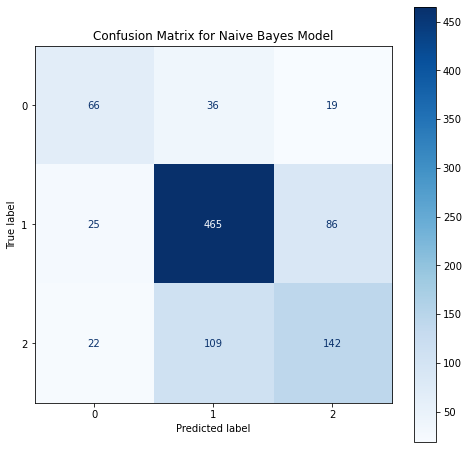

In [30]:
def create_confusion_matrix(model, model_name):
    fig, ax = plt.subplots(1, 1, figsize = (8,8))
    plot_confusion_matrix(model, X_test, y_test, cmap = 'Blues', ax = ax)
    plt.title(f'Confusion Matrix for {model_name} Model')
    plt.show()

create_confusion_matrix(nb_tuned, 'Naive Bayes')